## Import Libraries

In [0]:
import warnings
warnings.simplefilter(action='ignore', category = FutureWarning )

In [0]:
import numpy as np
np.set_printoptions(precision=4)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

In [0]:
### python 

from collections import defaultdict
import itertools

import h5py


In [0]:
### Scipy and openCV

In [0]:
### Scikit-learn packages

from sklearn.model_selection import train_test_split

In [6]:
### Installing tensorflow packages

!pip install tensorflow==2.0
!pip install tensorflow-gan

     |████████████████████████████████| 86.3MB 52kB/s 
     |████████████████████████████████| 450kB 52.9MB/s 
     |████████████████████████████████| 3.8MB 39.1MB/s 
     |████████████████████████████████| 81kB 12.0MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstall

In [7]:
### Tensorflow packages


import tensorflow as tf
print(tf.__version__)

# --------------- Disable the tensorflow version 2.0 ----------
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

2.0.0


In [8]:
# Check that imports for the rest of the file work.
import tensorflow as tf

import tensorflow_gan as tfgan
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
# Allow matplotlib images to render immediately.
%matplotlib inline

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # Disable noisy outputs.

In [9]:
### Keras packages

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.utils import to_categorical

from keras import layers
from keras.layers import Input, Dense, Activation, Dropout, BatchNormalization, Flatten, Conv1D , Reshape, Add, Concatenate
from keras.layers import AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D , Flatten, Conv2D, ZeroPadding2D
from keras.models import Sequential, Model

from keras.optimizers import RMSprop , SGD, Adam
from keras.callbacks import ModelCheckpoint


from keras.layers import LSTM, Cropping2D, Lambda, RepeatVector, Permute, Dot, Multiply




Using TensorFlow backend.


In [0]:
import pydot


from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model



In [0]:
%load_ext autoreload
%autoreload 2
from PIL import Image
import cv2
from keras.models import load_model

# sess = tf.Session()
from keras import backend as K
# K.set_session(sess)


K.set_image_data_format('channels_last')

## Load and Preprocess data

In [12]:
### For working on google colab

from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/SRGAN Project/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:

from pathlib import Path


In [0]:
import tensorflow_datasets as tfds

#### Input Pipeline

In [0]:
def input_fn(mode, params):
  assert 'batch_size' in params
  assert 'noise_dims' in params
  bs = params['batch_size']
  nd = params['noise_dims']
  split = 'train' if mode == tf.estimator.ModeKeys.TRAIN else 'test'
  shuffle = (mode == tf.estimator.ModeKeys.TRAIN)
  just_noise = (mode == tf.estimator.ModeKeys.PREDICT)
  
  noise_ds = (tf.data.Dataset.from_tensors(0).repeat()
              .map(lambda _: tf.random_normal([bs, nd])))
  
  if just_noise:
    return noise_ds

  def _preprocess(element):
    # Map [0, 255] to [-1, 1].
    images = (tf.cast(element['image'], tf.float32) - 127.5) / 127.5
    return images

  images_ds = (tfds.load('mnist', split=split)
               .map(_preprocess)
               .cache()
               .repeat())
  if shuffle:
    images_ds = images_ds.shuffle(
        buffer_size=10000, reshuffle_each_iteration=True)
  images_ds = (images_ds.batch(bs, drop_remainder=True)
               .prefetch(tf.data.experimental.AUTOTUNE))

  return tf.data.Dataset.zip((noise_ds, images_ds))

In [0]:
def input_fn1(mode, params):
  assert 'batch_size' in params
  assert 'noise_dims' in params
  bs = params['batch_size']
  ## nd = params['noise_dims']
  
  # split = 'train' if mode == tf.estimator.ModeKeys.TRAIN else 'test'
  # shuffle = (mode == tf.estimator.ModeKeys.TRAIN)
  just_lrimage = (mode == tf.estimator.ModeKeys.PREDICT)
  
  # noise_ds = (tf.data.Dataset.from_tensors(0).repeat()
  #            .map(lambda _: tf.random_normal([bs, nd])))

  if just_lrimage:
    return noise_ds

  def _preprocess(element):
    # Map [0, 255] to [-1, 1].
    images = (tf.cast(element['image'], tf.float32) - 127.5) / 127.5
    return images

  images_ds = (tfds.load('mnist', split=split)
               .map(_preprocess)
               .cache()
               .repeat())
  if shuffle:
    images_ds = images_ds.shuffle(
        buffer_size=10000, reshuffle_each_iteration=True)
  images_ds = (images_ds.batch(bs, drop_remainder=True)
               .prefetch(tf.data.experimental.AUTOTUNE))

  return tf.data.Dataset.zip((noise_ds, images_ds))

In [0]:
tf.compat.v1.set_random_seed(10)

In [0]:
list_ds = tf.data.Dataset.list_files(str(root_path + 'data/DIV2K_train_HR/hr_images/*'), shuffle = False)

In [17]:
for f in list_ds.take(5):
  print(f.numpy())

b'gdrive/My Drive/SRGAN Project/data/DIV2K_train_HR/hr_images/0001.png'
b'gdrive/My Drive/SRGAN Project/data/DIV2K_train_HR/hr_images/0002.png'
b'gdrive/My Drive/SRGAN Project/data/DIV2K_train_HR/hr_images/0003.png'
b'gdrive/My Drive/SRGAN Project/data/DIV2K_train_HR/hr_images/0004.png'
b'gdrive/My Drive/SRGAN Project/data/DIV2K_train_HR/hr_images/0005.png'


In [0]:


def decode_img(img, hr_img_shape = (96, 96) , lr_img_shape = (64, 64), original_image_shape = (2048, 1080) ):

  IMG_WIDTH, IMG_HEIGHT = hr_img_shape
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)

  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  
  # resize the image to the desired size.
  hr_img = tf.image.resize_with_crop_or_pad(img, IMG_HEIGHT , IMG_WIDTH) 

  # lr_img = tf.image.resize(img, [ int(original_img_shape[1]//4), int(original_img_shape[0]//4) ]  , method = 'bicubic' ) 
  # scipy.misc.imresize

  # lr_final_shape = np.min(int(original_img_shape[1]//4), int(original_img_shape[0]//4)) 

  lr_img = tf.image.resize(hr_img, [ int(hr_img_shape[1]//4), int(hr_img_shape[0]//4) ]  , method = 'bicubic' ) 

  return lr_img, hr_img




In [0]:
discriminator_img_shape = (256, 256)
original_img_shape = (2048, 1080)
generator_img_shape = (96, 96)
def process_path(file_path, hr_img_shape = discriminator_img_shape , lr_img_shape = generator_img_shape, original_image_shape = original_img_shape ):
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  lr_img, hr_img = decode_img(img , hr_img_shape = hr_img_shape , lr_img_shape = lr_img_shape ,original_image_shape = original_image_shape )
  return lr_img , hr_img

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
images_ds = list_ds.map(process_path, num_parallel_calls= AUTOTUNE)

In [21]:
images_ds

<DatasetV1Adapter shapes: ((64, 64, 3), (256, 256, 3)), types: (tf.float32, tf.float32)>

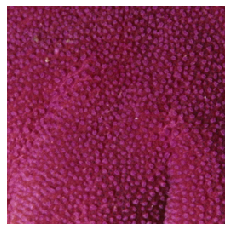

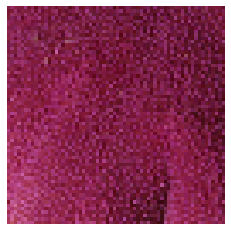

In [22]:
 
numpy_imgs1 = next(tfds.as_numpy(images_ds))[1]
numpy_imgs2 = next(tfds.as_numpy(images_ds))[0]

# img_grid = tfgan.eval.python_image_grid(numpy_imgs1, grid_shape=(10, 10))
# img_grid2 = tfgan.eval.python_image_grid(numpy_imgs2, grid_shape=(10, 10))
plt.axis('off')
plt.imshow(numpy_imgs1)

plt.show()
plt.axis('off')
plt.imshow(numpy_imgs2)
plt.show()

In [0]:
lr_img_ds = images_ds.interleave(lambda lr_img,hr_img: tf.data.Dataset.from_tensors(lr_img))
hr_img_ds = images_ds.interleave(lambda lr_img,hr_img: tf.data.Dataset.from_tensors(hr_img))

In [24]:
for images in hr_img_ds.take(1):
  print("Image shape: ", images.shape)

Image shape:  (256, 256, 3)


In [0]:

def show_hr_image(image, label = 'high resolution image example', img_ids_hr = 1):
  image = (tf.cast(image, tf.float32) * 127.5 ) + 127.5
  plt.figure(figsize=(10, 10))
  plt.imshow(image)
  plt.title(label)
  plt.axis('off')
  plt.savefig(root_path + "example_images/highres/img_{}.png" .format(img_ids_hr ) )


def show_lr_image(image, label = 'low resolution image example', img_ids_lr = 1):
  image = (tf.cast(image, tf.float32) * 255.0 ) 
  plt.figure(figsize=(10, 10))
  plt.imshow(image)
  plt.title(label)
  plt.axis('off')
  plt.savefig(root_path + "example_images/lowres/img{}.png" .format(img_ids_lr ) )



In [0]:
def _hr_preprocess(element):
    # Map [0, 255] to [-1, 1].
    images = (tf.cast(element, tf.float32) - 127.5) / 127.5
    return images

def _lr_preprocess(element):

    # Map [0, 255] to [0, 1].
    images = (tf.cast(element, tf.float32)) / 255.0
    
    return images

In [0]:
highres_images = hr_img_ds.map(_hr_preprocess)

In [110]:

for i, image1 in enumerate(highres_images.take(20)):  
  show_hr_image(image1, img_ids_hr = i+1)


Output hidden; open in https://colab.research.google.com to view.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

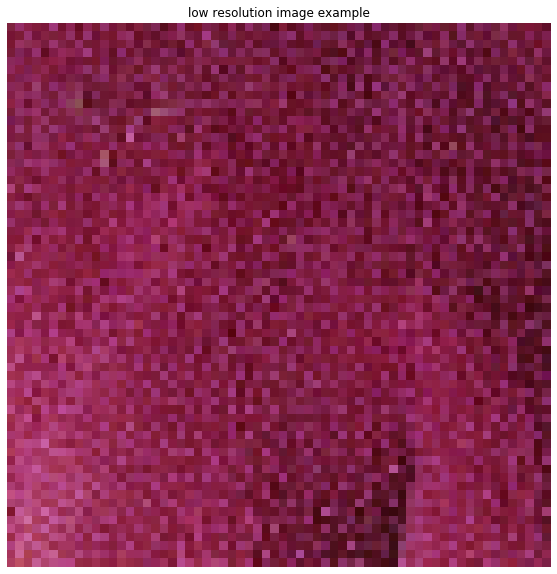

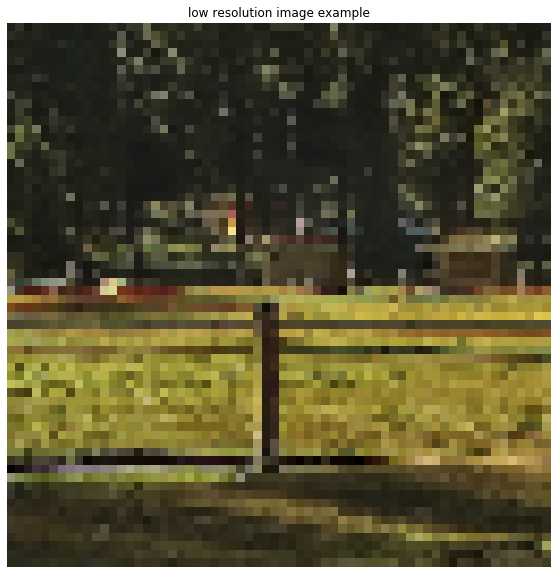

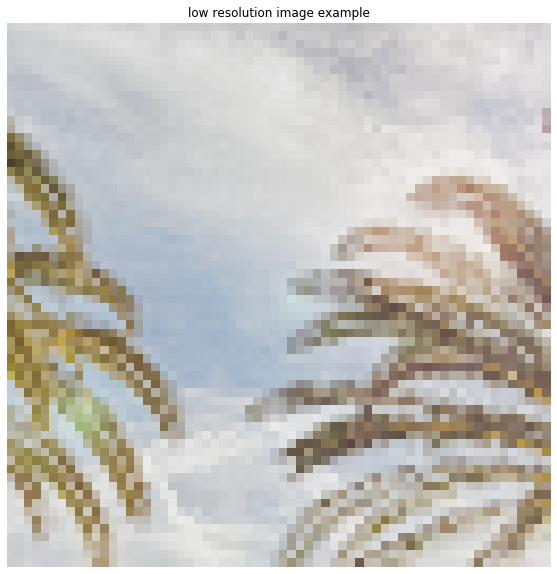

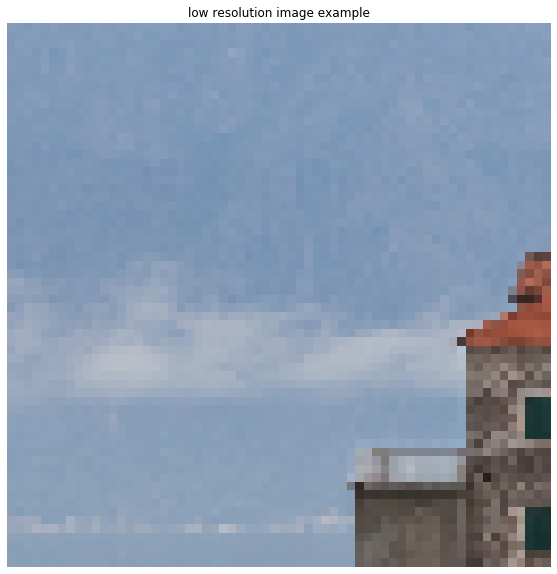

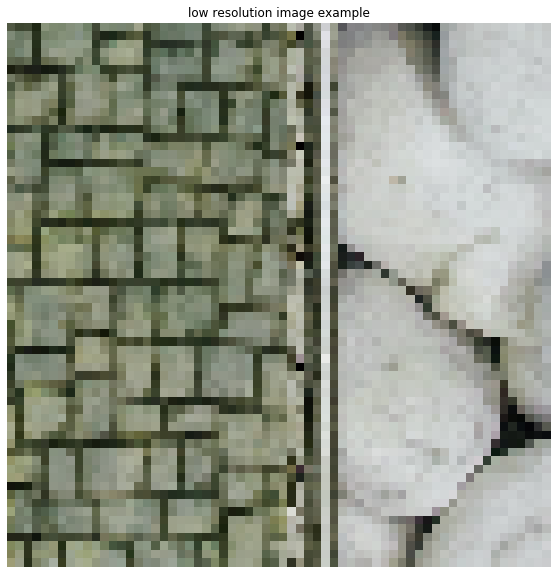

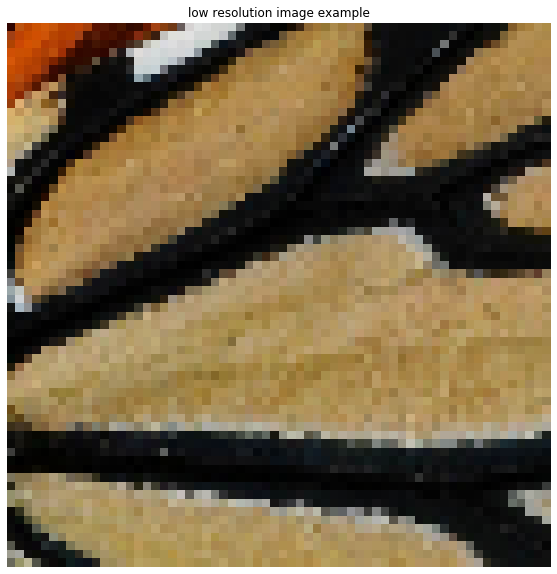

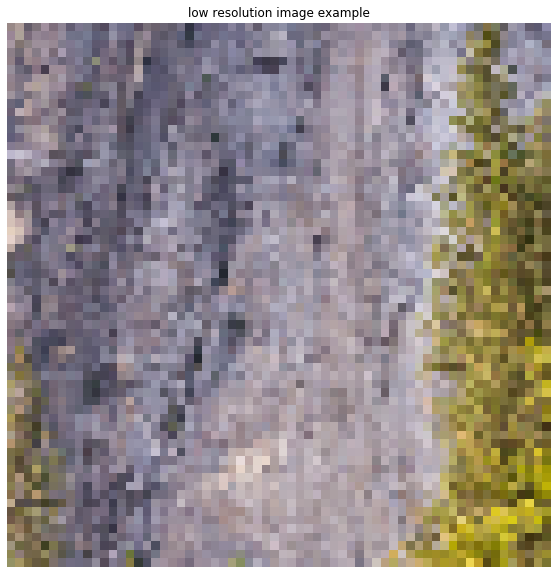

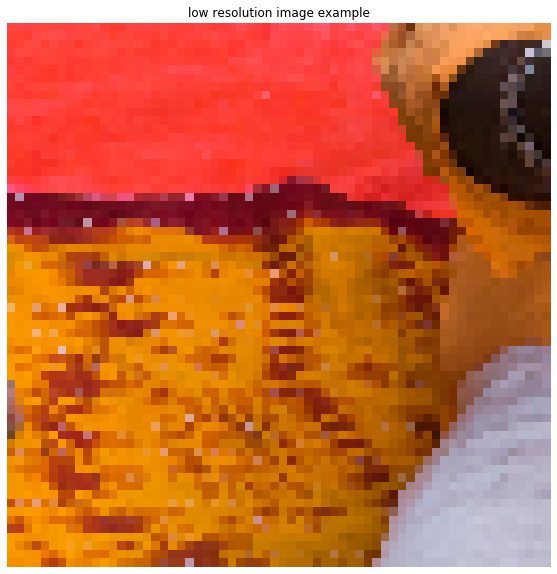

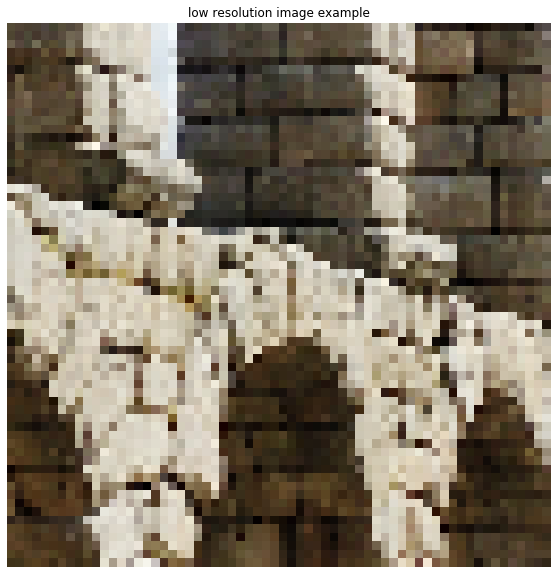

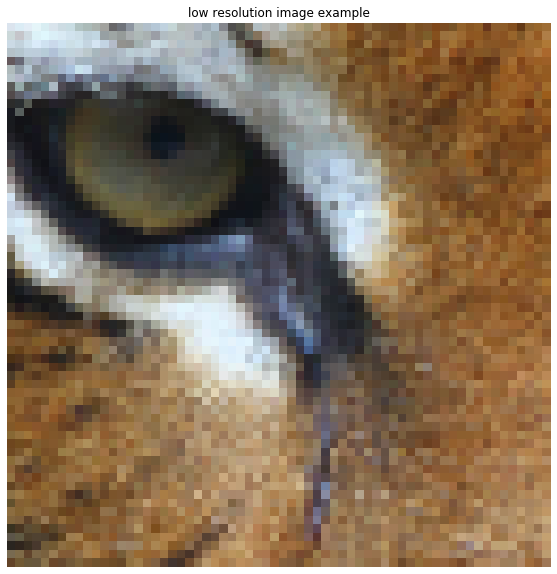

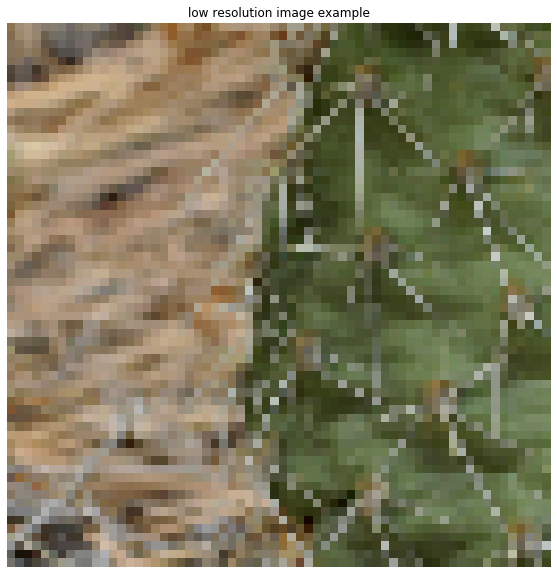

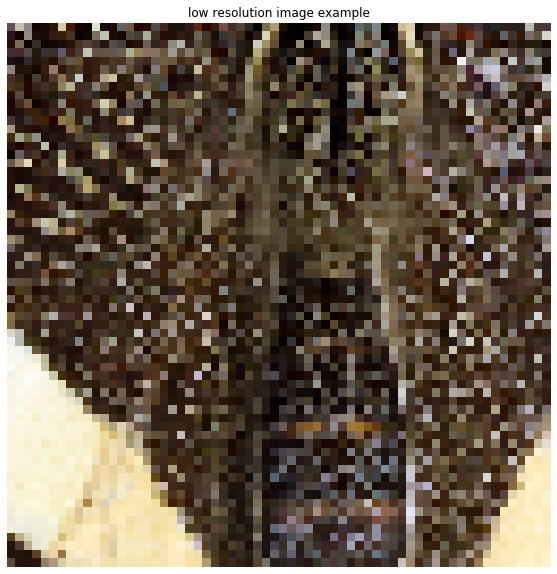

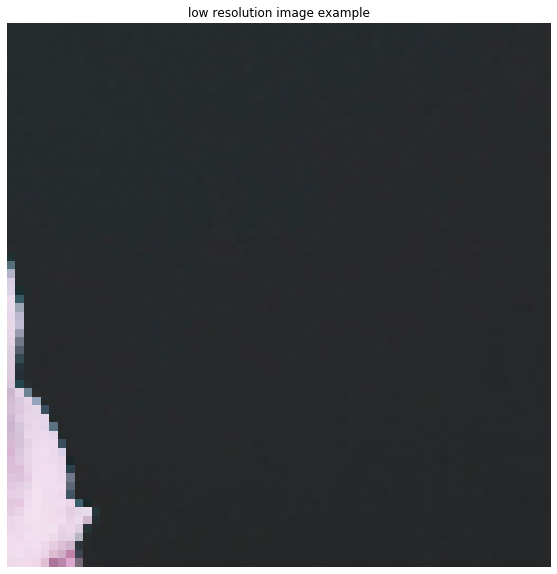

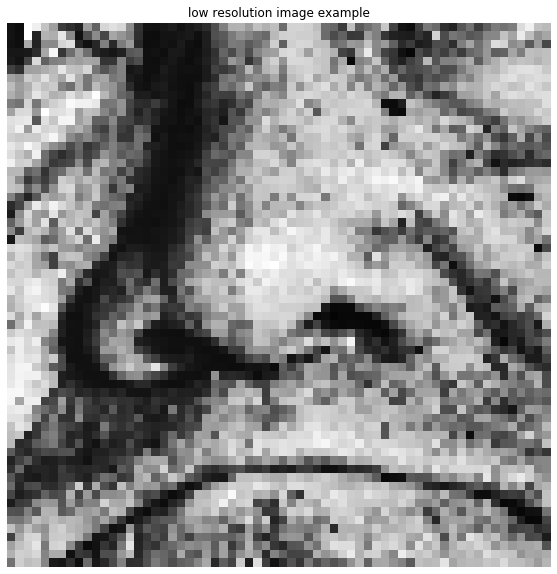

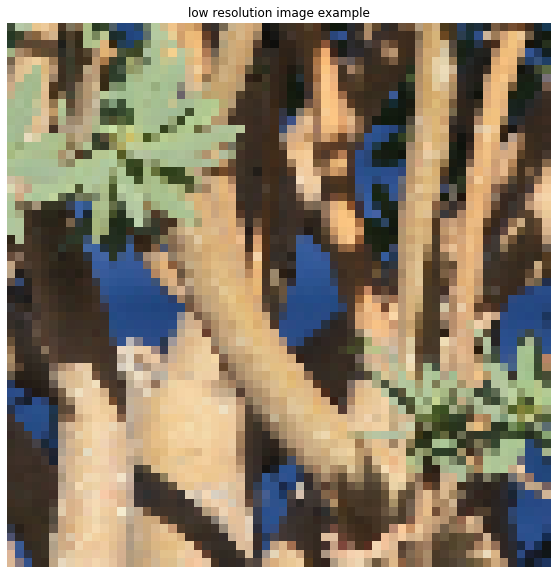

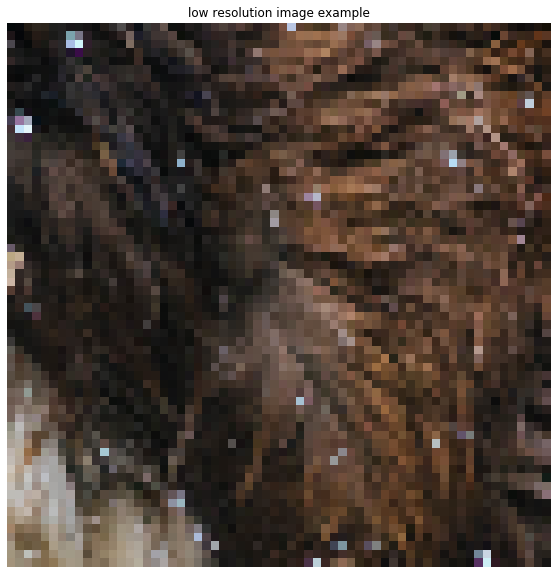

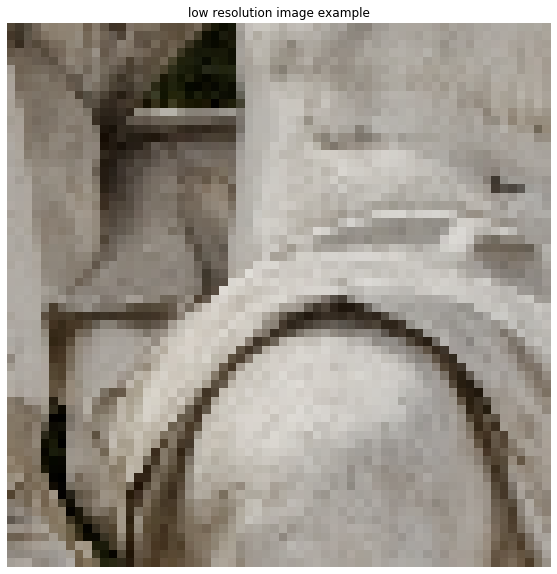

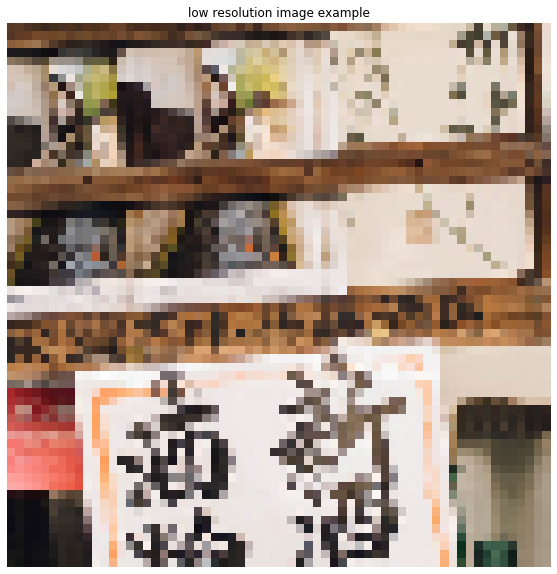

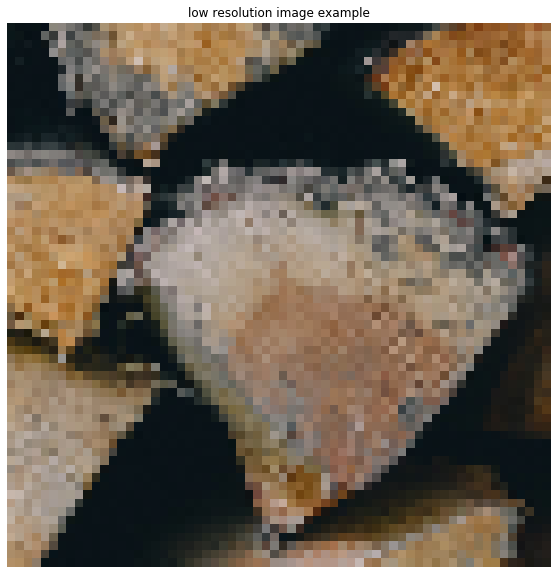

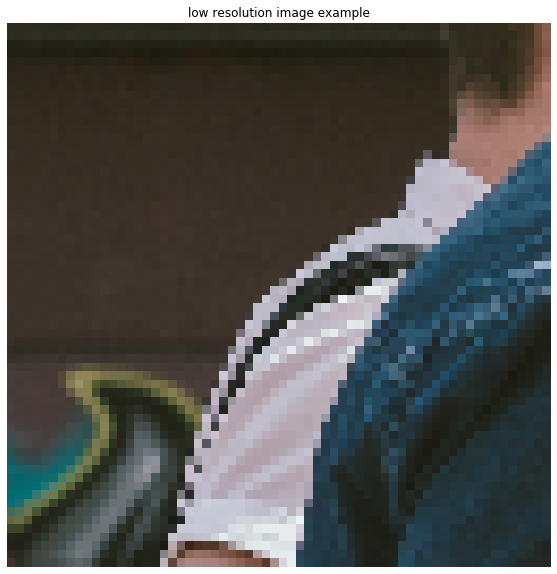

In [109]:
lowres_images = lr_img_ds.map(_lr_preprocess)
for j,image2 in enumerate(lowres_images.take(20)):  
  show_lr_image(image2, img_ids_lr= j + 1 )

### Using flow generator

In [0]:
# input_images = tf.keras.utils.get_file(
#     'data/DIV2K_train_HR', origin = root_path)

In [26]:
input_images = root_path + 'data/DIV2K_train_HR/'
img_gen = tf.keras.preprocessing.image.ImageDataGenerator()
images, labels = next(img_gen.flow_from_directory(input_images))

Found 800 images belonging to 1 classes.


In [27]:
print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

float32 (32, 256, 256, 3)
float32 (32, 1)


In [28]:
input_images_ds = tf.data.Dataset.from_generator(
    img_gen.flow_from_directory, 
    output_types=(tf.float32),
    output_shapes = ([None,96,96,3])
)

input_images_ds

<DatasetV1Adapter shapes: (None, 96, 96, 3), types: tf.float32>

In [29]:
input_images_ds.shuffle(buffer_size=10000, reshuffle_each_iteration=True).repeat()

<DatasetV1Adapter shapes: (None, 96, 96, 3), types: tf.float32>

TypeError: ignored

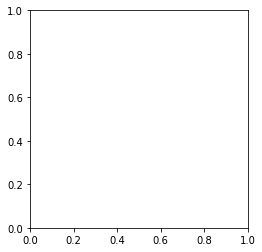

In [33]:
show() 

In [0]:
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
import numpy as np

params = {'batch_size': 100, 'noise_dims':64}
with tf.Graph().as_default():
  ds = input_fn(tf.estimator.ModeKeys.TRAIN, params)
  numpy_imgs = next(tfds.as_numpy(ds))[1]
img_grid = tfgan.eval.python_image_grid(numpy_imgs, grid_shape=(10, 10))
plt.axis('off')
plt.imshow(np.squeeze(img_grid))
plt.show()